## Data Analysis Project on Home Court Advantage and Predicting Home Winning Percentage

In [27]:
#Loading up our libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

## Look at our Data
To start this project off, let's look at our data and see what we are working with. We are also conducting Exploratory Data Analysis to get an overview on what kind of data we can work with.

In [28]:
df= pd.read_csv("game.csv")

#Creating a season column
df['season'] = df['season_id'].astype(str).str[-4:]
#Only using regular season and Playoff games as this list includes additional games
df = df[(df['season_type'] == "Playoffs") | (df['season_type'] == "Regular Season")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64034 entries, 0 to 65695
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season_id               64034 non-null  int64  
 1   team_id_home            64034 non-null  int64  
 2   team_abbreviation_home  64034 non-null  object 
 3   team_name_home          64034 non-null  object 
 4   game_id                 64034 non-null  int64  
 5   game_date               64034 non-null  object 
 6   matchup_home            64034 non-null  object 
 7   wl_home                 64034 non-null  object 
 8   min                     64034 non-null  int64  
 9   fgm_home                64021 non-null  float64
 10  fga_home                48587 non-null  float64
 11  fg_pct_home             48544 non-null  float64
 12  fg3m_home               50867 non-null  float64
 13  fg3a_home               45402 non-null  float64
 14  fg3_pct_home            45013 non-null  flo

In [29]:
#Home Winning Percentage
df['home_win'] = df['wl_home'].map({'W': 1, 'L': 0})
home_win_pct = df['home_win'].mean()
print(f"Home Win Percentage: {home_win_pct:.3f}")

Home Win Percentage: 0.620


In [30]:
#Average Points at home versus away
home_pts_avg = df['pts_home'].mean()
away_pts_avg = df['pts_away'].mean()
print(f"Avg Home Points: {home_pts_avg:.2f}")
print(f"Avg Away Points: {away_pts_avg:.2f}")

Avg Home Points: 104.67
Avg Away Points: 101.02


In [31]:
df['point_diff'] = df['pts_home'] - df['pts_away']
home_avg_margin = df['point_diff'].mean()
print(f"Average Home Margin of Victory: {home_avg_margin:.2f}")

Average Home Margin of Victory: 3.65


## Differences in Rebounding, Assists, Steals, Blocks, FG%,3P%,and FT%

In [32]:
stat_cols = ['reb', 'ast', 'stl', 'blk', 'fg_pct', 'fg3_pct', 'ft_pct']
for stat in stat_cols:
    home_stat = df[f'{stat}_home'].mean()
    away_stat = df[f'{stat}_away'].mean()
    stat_diff=home_stat-away_stat
    print(f"{stat.upper()} — Home: {home_stat:.2f}, Away: {away_stat:.2f}")
    print(f'Difference Between Home and Away: {stat_diff:.4f}')


REB — Home: 43.73, Away: 42.08
Difference Between Home and Away: 1.6587
AST — Home: 23.98, Away: 22.16
Difference Between Home and Away: 1.8222
STL — Home: 7.96, Away: 7.81
Difference Between Home and Away: 0.1452
BLK — Home: 5.32, Away: 4.69
Difference Between Home and Away: 0.6332
FG_PCT — Home: 0.47, Away: 0.46
Difference Between Home and Away: 0.0124
FG3_PCT — Home: 0.35, Away: 0.34
Difference Between Home and Away: 0.0096
FT_PCT — Home: 0.76, Away: 0.75
Difference Between Home and Away: 0.0027


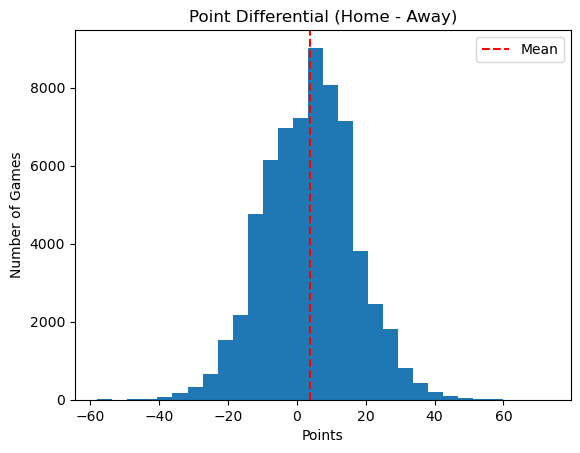

In [33]:
#Plotting our values
plt.hist(df['point_diff'], bins=30)
plt.axvline(df['point_diff'].mean(), color='red', linestyle='--', label='Mean')
plt.title('Point Differential (Home - Away)')
plt.xlabel('Points')
plt.ylabel('Number of Games')
plt.legend()
plt.show()

In [34]:
df['home_win'] = df['wl_home'].map({'W': 1, 'L': 0})
home_win_by_season = df.groupby('season')['home_win'].mean()
home_win_by_season

season
1946    0.620000
1947    0.581395
1948    0.639474
1949    0.698145
1950    0.752632
          ...   
2018    0.590701
2019    0.546410
2020    0.545064
2021    0.547456
2022    0.581431
Name: home_win, Length: 76, dtype: float64

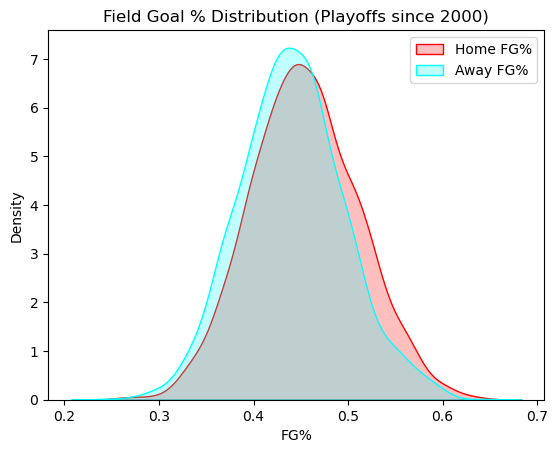

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

#Let's look at playoff games since the 2000s since the 2000s

df['season'] = df['season'].astype(int)
df_present = df[(df['season'] >= 2000) & (df['season_type'] == "Playoffs")]
sns.kdeplot(df_present['fg_pct_home'], label='Home FG%', fill=True,color='red')
sns.kdeplot(df_present['fg_pct_away'], label='Away FG%', fill=True,color='cyan')
plt.title('Field Goal % Distribution (Playoffs since 2000)')
plt.xlabel('FG%')
plt.legend()
plt.show()

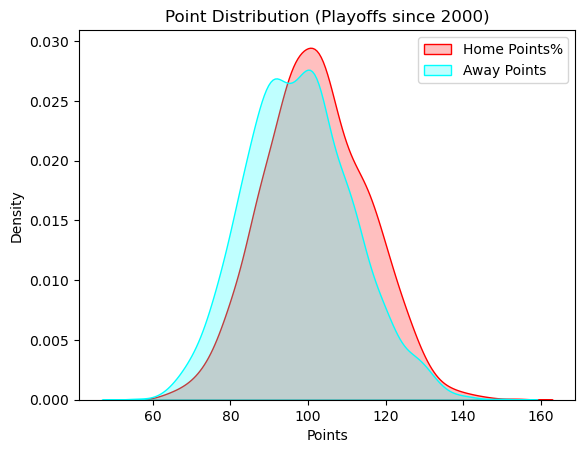

In [36]:
sns.kdeplot(df_present['pts_home'], label='Home Points%', fill=True,color='red')
sns.kdeplot(df_present['pts_away'], label='Away Points', fill=True,color='cyan')
plt.title('Point Distribution (Playoffs since 2000)')
plt.xlabel('Points')
plt.legend()
plt.show()

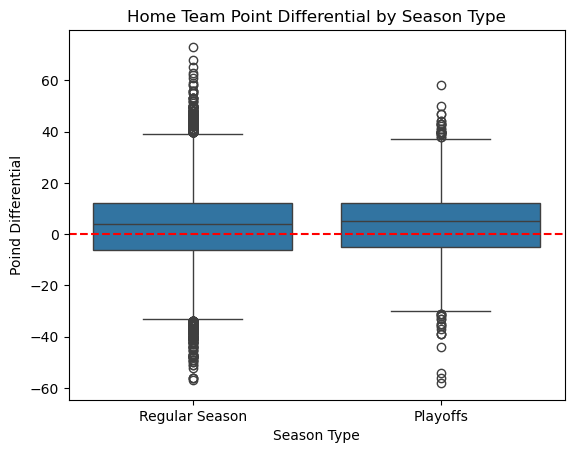

In [37]:
#Let's only look at Regular Season and Playoffs to get a good picture
df['point_diff'] = df['pts_home'] - df['pts_away']
sns.boxplot(x='season_type', y='point_diff', data=df)
plt.title('Home Team Point Differential by Season Type')
plt.xlabel('Season Type')
plt.ylabel('Poind Differential')
plt.axhline(0, linestyle='--', color='red')
plt.show()

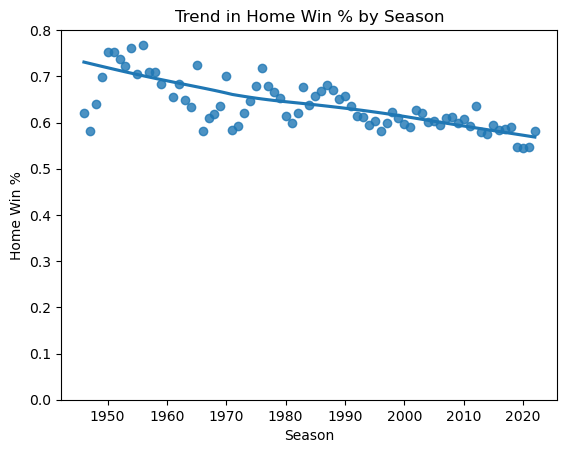

In [38]:
#Why don't we look at win percentage over time
season_win_rate = df.groupby('season')['home_win'].mean().reset_index()

sns.regplot(data=season_win_rate, x='season', y='home_win', scatter=True, lowess=True)
plt.title('Trend in Home Win % by Season')
plt.ylim(0, 0.8)
plt.ylabel("Home Win %")
plt.xlabel("Season")
plt.show()

#That 1960 outlier needs to be investigated

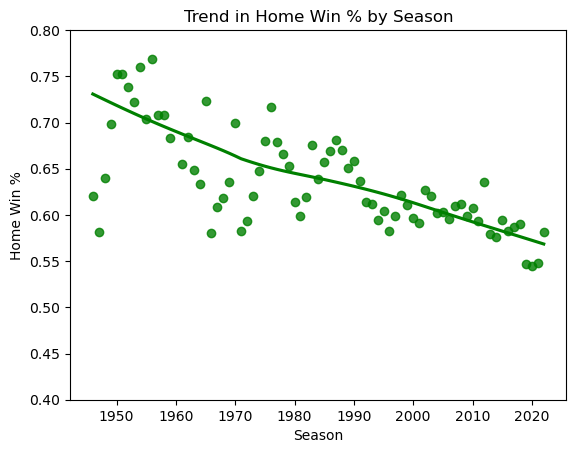

In [39]:
#Looking into this we found out there was only one game recorded in 1960 so it will be removed from our data doing onwards
df_1960=df[df['season']==1960]
len(df_1960) #Just one game



df=df[df['season']!=1960]
season_win_rate = df.groupby('season')['home_win'].mean().reset_index()

#Updated without 1960 outlier since data was incomplete
sns.regplot(data=season_win_rate, x='season', y='home_win', scatter=True, lowess=True,color='green')
plt.title('Trend in Home Win % by Season')
plt.ylim(0.4, 0.8)
plt.ylabel("Home Win %")
plt.xlabel("Season")
plt.show()


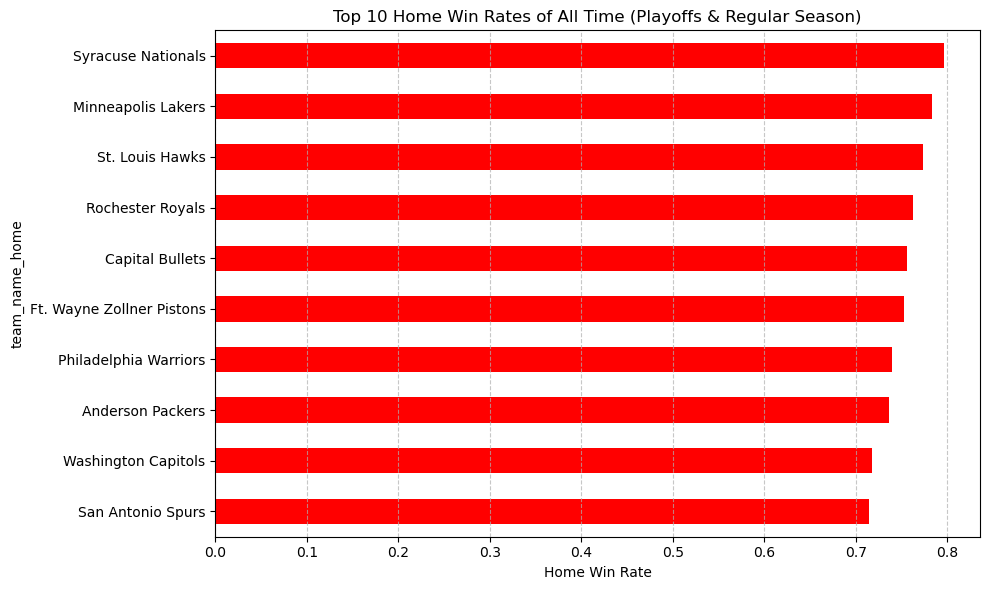

In [40]:
df['home_win'] = df['wl_home'].map({'W': 1, 'L': 0})
team_home_winrate = df.groupby('team_name_home')['home_win'].mean().sort_values(ascending=False)
team_home_winrate.head(10)

top10 = team_home_winrate.head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='barh', color='red')
plt.title('Top 10 Home Win Rates of All Time (Playoffs & Regular Season)')
plt.xlabel('Home Win Rate')
plt.gca().invert_yaxis()  # Highest win rate at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

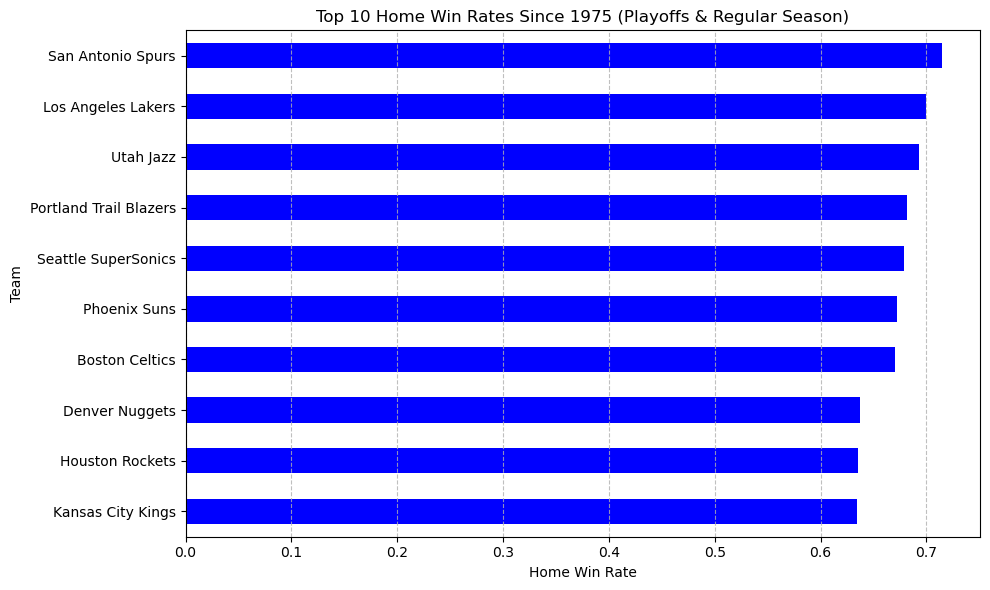

In [41]:
#Check 2000s for Best Home Win Rate
df_present = df[(df['season'] >= 1975)]

df_present['home_win'] = df_present['wl_home'].map({'W': 1, 'L': 0})
team_home_winrate = df_present.groupby('team_name_home')['home_win'].mean().sort_values(ascending=False)
team_home_winrate.head(10)

top10 = team_home_winrate.head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='barh', color='blue')
plt.title('Top 10 Home Win Rates Since 1975 (Playoffs & Regular Season)')
plt.xlabel('Home Win Rate')
plt.ylabel("Team")
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


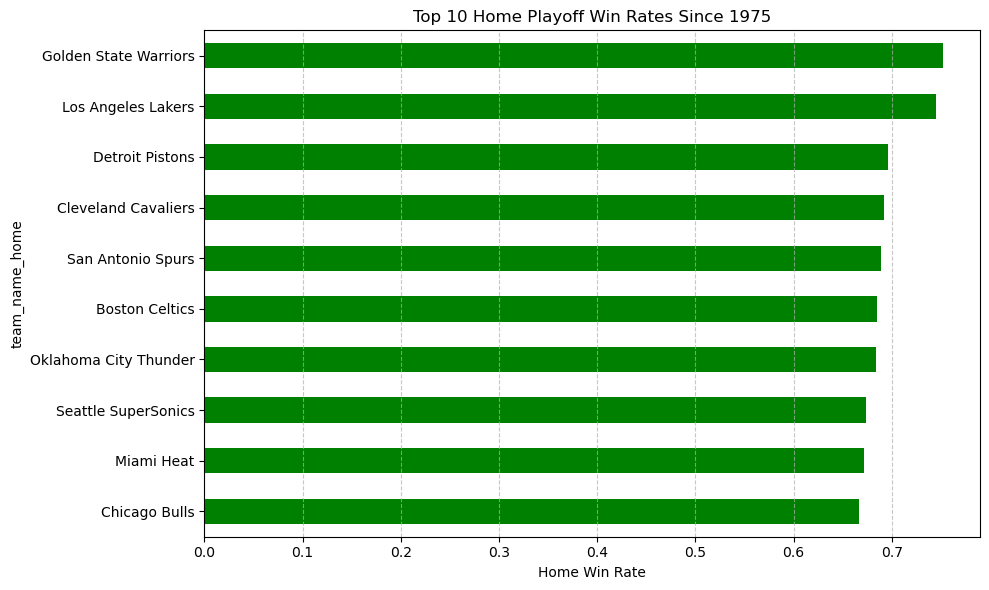

In [42]:
df_playoffs = df[(df['season'] >= 1975) & (df['season_type'] == "Playoffs")].copy()

# Create home_win binary variable
df_playoffs['home_win'] = df_playoffs['wl_home'].map({'W': 1, 'L': 0})

# Calculate average home win rate by team
team_home_winrate = df_playoffs.groupby('team_name_home')['home_win'].mean().sort_values(ascending=False)

# Plot top 10 teams
top10 = team_home_winrate.head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='barh', color='green')
plt.title('Top 10 Home Playoff Win Rates Since 1975')
plt.xlabel('Home Win Rate')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Winning at Oracle Arena was a nightmare for many opposing teams

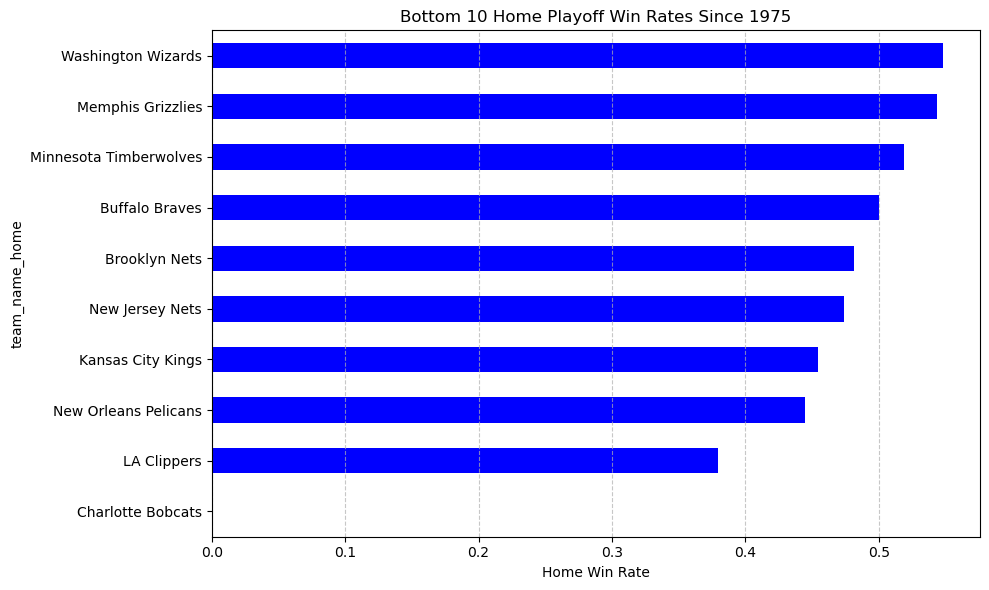

In [43]:
df_playoffs = df[(df['season'] >= 1975) & (df['season_type'] == "Playoffs")].copy()
df_playoffs['home_win'] = df_playoffs['wl_home'].map({'W': 1, 'L': 0})

#Mean Home Rate
team_home_winrate = df_playoffs.groupby('team_name_home')['home_win'].mean().sort_values(ascending=False)

# Plot Bottom 10 teams
top10 = team_home_winrate.tail(10)
plt.figure(figsize=(10, 6))
top10.plot(kind='barh', color='blue')
plt.title('Bottom 10 Home Playoff Win Rates Since 1975')
plt.xlabel('Home Win Rate')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Let us do some Linear Regression to Predict Point Differential of Games since 1975

In [44]:
df_model = df[df['season'] >= 1975].copy()
df_model['point_diff'] = df_model['pts_home'] - df_model['pts_away']

#Selecting our predictors to make this happen
features = [
    'fg_pct_home', 'reb_home', 'ast_home', 'tov_home', 'stl_home', 'blk_home', 'pf_home', 'fta_home', 'fg3_pct_home',
    'fg_pct_away', 'reb_away', 'ast_away', 'tov_away', 'stl_away', 'blk_away', 'pf_away', 'fta_away', 'fg3_pct_away'
]
df_model = df_model.dropna(subset=features + ['point_diff'])
X = df_model[features]
y = df_model['point_diff']
X = sm.add_constant(X)
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             point_diff   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 1.662e+04
Date:                Fri, 04 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:22:49   Log-Likelihood:            -1.3338e+05
No. Observations:               44640   AIC:                         2.668e+05
Df Residuals:                   44621   BIC:                         2.670e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.6227      0.572     -1.088   

## Takeaways
- Shooting efficiency and turnovers are the biggest drivers of point differential
- Model is strong and balances
- No signs of autocorrelation or skew

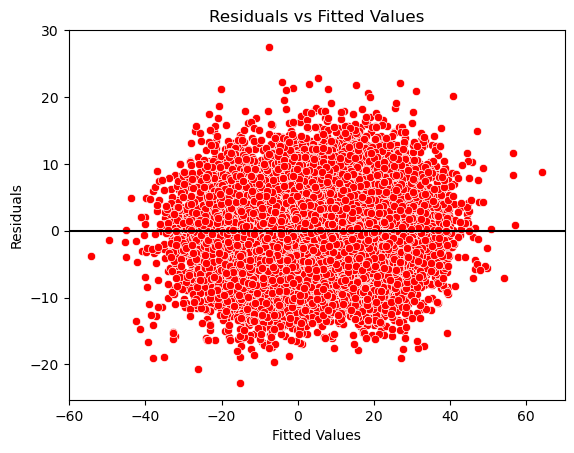

In [45]:
#Let us look at residuals
residuals = ols_model.resid
fitted = ols_model.fittedvalues
sns.scatterplot(x=fitted, y=residuals,color='red')
plt.axhline(0, linestyle='-', color='black')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

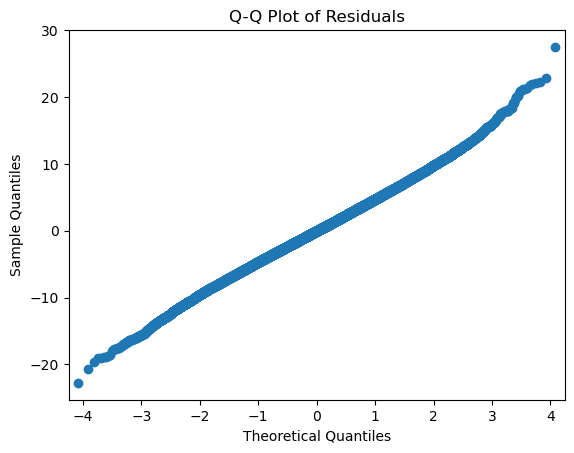

In [46]:
sm.qqplot(ols_model.resid,color='red')
plt.title("Q-Q Plot of Residuals")
plt.show()

## Our Residuals and QQ Plot look solid
- Some minor residuals and outliers but nothing to significantly shift the plot
- Overall a good fit

In [47]:
#Top features
features = [
    'fg_pct_home', 'reb_home', 'ast_home', 'tov_home', 'stl_home', 'blk_home', 'pf_home', 'fta_home', 'fg3_pct_home',
    'fg_pct_away', 'reb_away', 'ast_away', 'tov_away', 'stl_away', 'blk_away', 'pf_away', 'fta_away', 'fg3_pct_away'
]
target = 'point_diff'

df_model = df[df['season'] >= 1975].copy()
df_model['point_diff'] = df_model['pts_home'] - df_model['pts_away']
df_model = df_model.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()

y_pred = model.predict(X_test_const)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Test RMSE: 4.845
Test R²: 0.868


## This confirms the strength of our model

In [48]:
y_train_pred = model.predict(X_train_const)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
r2 = r2_score(y_train, y_train_pred)
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Train RMSE: 4.784
Test R²: 0.871


## We will now try win/loss predictions using Logistic Regression

In [49]:
# Feature set 
features = [
    'fg_pct_home', 'reb_home', 'ast_home', 'tov_home', 'stl_home', 'blk_home', 'pf_home', 'fta_home', 'fg3_pct_home',
    'fg_pct_away', 'reb_away', 'ast_away', 'tov_away', 'stl_away', 'blk_away', 'pf_away', 'fta_away', 'fg3_pct_away'
]

# Drop rows with NA values
X = df[features].dropna()
#We are working with binaries
y = df.loc[X.index, 'wl_home'].map({'W': 1, 'L': 0}) 

# Split + scale

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

#Predictions and Results
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]
print("Logistic Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Accuracy: 0.9245519713261648
Logistic ROC AUC: 0.9793050771045797
[[3926  432]
 [ 410 6392]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4358
           1       0.94      0.94      0.94      6802

    accuracy                           0.92     11160
   macro avg       0.92      0.92      0.92     11160
weighted avg       0.92      0.92      0.92     11160



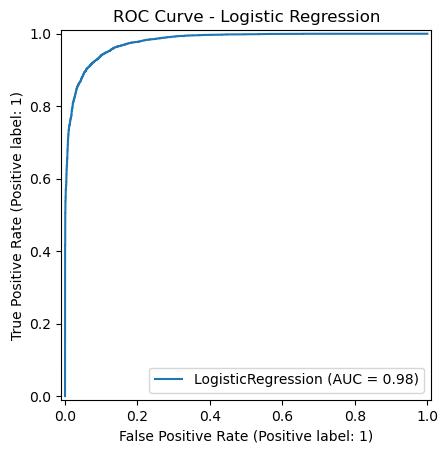

In [50]:
RocCurveDisplay.from_estimator(log_model, X_test_scaled, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

In [51]:

X = df[features].dropna()
y = df.loc[X.index, 'wl_home'].map({'W': 1, 'L': 0}) 

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Prediction and outputs
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))




Random Forest Accuracy: 0.8942652329749103
Random Forest ROC AUC: 0.9617370859392785
[[3690  668]
 [ 512 6290]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      4358
           1       0.90      0.92      0.91      6802

    accuracy                           0.89     11160
   macro avg       0.89      0.89      0.89     11160
weighted avg       0.89      0.89      0.89     11160



## Logistic Regression takes it here but solid performances overall